<a href="https://colab.research.google.com/github/akshaya-nagarajan/DeepLearningProjects/blob/master/Assignment_2/DLAssignment2_Scratch_AutoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoDiff From Scratch

## Import Required Libraries

In [0]:
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

## Creating a Tensor Class

In [0]:
class Tensor:
  def __init__(self, data, requires_grad=False):
      self.data = data
      if not isinstance(data, np.ndarray):
          self.data = np.array(data)
      # whether to run backpropagation or not
      self.requires_grad = requires_grad
      # tensor gradient
      self._grad = None
      # operation if this tensor was used in it
      self._grad_fn = None

  @property
  def shape(self):
      return self.data.shape

  @property
  def grad_fn(self):
      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')
      return self._grad_fn

  @property
  def grad(self):
      return self._grad

  def backward(self, grad=None):
      if not self.grad_fn:
          return False

      if grad is None and self._grad is None:
          grad = self.__class__(1., requires_grad=False)

      elif self.grad is not None:
          grad = self._grad

      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')

      self.grad_fn.backward(grad)
      return True

  def __str__(self):
      return f'Tensor({str(self.data)})'

  def add_grad(self, grad):
      if self._grad is None:
          self._grad = grad
      else:
          self._grad += grad

  def __add__(self, o): 
      if self.data is not None:
          self.data += o.data  
          return self
      self.data = o.data 
      return self

## Creating an Operation Class

In [0]:
class Op:
  def forward(self):
      raise NotImplemented

  def backward(self, grad):
      raise NotImplemented

  def __call__(self, *args):
      self.out = self.forward(*args)
      self.out._grad_fn = self
      return self.out

## Creating an Add Operation Class for adding 2 tensors

In [0]:
class AddOp(Op):
  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data + y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:
          if self.x.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
              self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.x.add_grad(grad)
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          if self.y.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
              self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.y.add_grad(grad)
          if self.y.grad_fn:
              self.y.backward()

## Creating a Multiplication Operation Class for multiplying 2 tensors

In [0]:
class MulOp(Op):
  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data * y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:
          print(self.x, self.x._grad, grad)
          self.x.add_grad(Tensor(grad.data * self.y.data, False))
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          self.y.add_grad(Tensor(grad.data * self.x.data, False))
          if self.y.grad_fn:
              self.y.backward()

## Creating a Layer Class to be inherited by other Classes like Relu, Sigmoid, etc.,

In [0]:
class Layer:
  def forward(self):
      raise NotImplemented
  
  def backward(self, grad):
      raise NotImplemented

  def __call__(self, *args):
      return self.forward(*args)

## Creating a Sigmoid Layer Class

In [0]:
class Sigmoid:
  def forward(self,x):
      self.x = x   
      return 1/(1+np.exp(-x))
    
  def backward(self, grad):
      grad_input = self.x*(1-self.x) * grad
      return grad_input

## Creating a Relu Layer Class

In [0]:
class Relu(Layer):
  def forward(self,x):
      self.x = x
      return np.maximum(np.zeros_like(x), x)
    
  def backward(self, grad):
      grad_input = (self.x > 0) * grad
      return grad_input

In [0]:
## Creating a Softmax Layer Class

In [0]:
class SoftmaxCrossentropyWithLogits(Layer):
  def forward(self, x, y):
      self.x = x
      self.y = y
      exps = np.exp(x) 
      self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)
      logits = self.softmax[np.arange(x.shape[0]),y]
      log_likelihood = -np.log(logits)
      loss = np.sum(log_likelihood) / x.shape[0]
      return loss
    
  def backward(self, grad=None):
      batch = self.x.shape[0]
      grad = self.softmax
      grad[np.arange(batch),self.y] -= 1
      grad = grad/batch
      return grad

## Creating a Mean Squared Error Class

In [0]:
class MSE(Layer):
  def forward(self, x, y):
      self.x = x
      self.y = y
      return ((x - y)**2) / (self.x.shape[0]*2)

  def backward(self, grad=None):
      return (self.x - self.y) / self.x.shape[0]

## Creating a Linear Layer Class

In [0]:
class Linear(Layer):
  def __init__(self, input, output, lr=0.0001):
      self.A = 2*np.random.random((input, output)) - 1
      self.b = 2*np.random.random((output)) - 1
      self.lr = lr

  def forward(self, x):
      self.x = x
      return np.dot(x,self.A) + self.b

  def backward(self, grad):
      b_grad = grad.mean(axis=0)*self.x.shape[0]
      A_grad = np.dot(self.x.T, grad)
      grad_input = np.dot(grad, self.A.T)
      self.A -= A_grad * self.lr
      self.b -= b_grad * self.lr
      return grad_input

In [0]:
class Model(Layer):
  def __init__(self, lr=0.0001):
      self.lr = lr
      self.layers = [Linear(3,15, lr=self.lr), Relu(), Linear(15,1, lr=self.lr)]
  def forward(self,x):
      for l in self.layers:
          x = l(x)
      return x
  def backward(self, grad):
      for l in self.layers[::-1]:
          grad = l.backward(grad)
      return grad

mm = Model()

def yf(x1,x2,x3):
    return np.array([2 * x1 + 3*x2 + 4*x3 + 5],dtype=np.float32)

loss = MSE()

for i in range(20000):
    x1 = np.random.random()*30
    x2 = np.random.random()*20
    x3 = np.random.random()*11
    y = mm(np.array([[x1,x2,x3]]))
    err = loss(y, yf(x1,x2,x3))   
    yb = loss.backward()
    yb = mm.backward(yb)

In [0]:
class Model(Layer):
    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [Linear(784,100, lr=self.lr), Relu(), Linear(100,200, lr=self.lr), Relu(), Linear(200,10, lr=self.lr)]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)
        return grad


simple = transforms.Compose([transforms.ToTensor()])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 

for e in range(5):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()
        res = mm(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


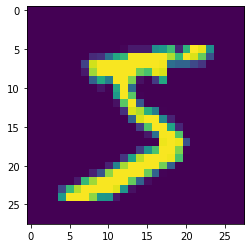

target: 5 predicted: 5


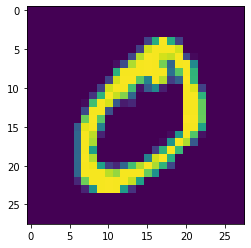

target: 0 predicted: 0


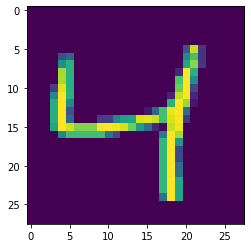

target: 4 predicted: 4


In [0]:
for i in range(3):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )